In [13]:
#Chapter 3
import numpy as np

In [2]:
#loading data from sklearn
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
X, y = mnist['data'], mnist['target'] #images and labels
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (70000, 784)
y shape: (70000,)


In [6]:
#784 = 28x28 pixels, this is an iamge, and there are 70000 images

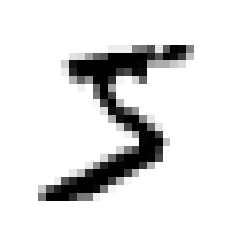

label for this image: 5


In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0] #originally this is a list with length = 784
some_digit_image = some_digit.reshape(28, 28) #reshape the list to a matrix 28x28

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

print('label for this image:', y[0])
y = y.astype(np.uint8) #string to int

In [18]:
#training and test set split
#since sklearn mnist dataset is already split we just need to
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [19]:
#Binary classifier

In [20]:
#The 'dataset' for this binary classifier
#in this case the model will only return 5 or not 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) #set random_state to 42 to match the book example
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
sgd_clf.predict([some_digit])

array([ True])

In [26]:
#Performance measures for classifiers

In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle = True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [36]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

#the result is due to 5 being about 10% of the dataset ;)
#at this point I can say that acc is not the big deal on metrics, at least not alone

array([0.91125, 0.90855, 0.90915])

In [37]:
#Confusion Matrix

In [50]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_pred)
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[ True False False ...  True False False]
[[53892   687]
 [ 1891  3530]]


In [51]:
#confusion matrix for a perfect classifier
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [54]:
#checking precision and recall through sklearn function and cm
from sklearn.metrics import precision_score, recall_score
#precision
print("precision")
print(precision_score(y_train_5, y_train_pred))
precision_cm = (cm[1,1]/(cm[0,1]+cm[1,1]))
print(precision_cm)

print("\nrecall")
print(recall_score(y_train_5, y_train_pred))
recall_cm = (cm[1,1]/(cm[1,0]+cm[1,1]))
print(recall_cm)

precision
0.8370879772350012
0.8370879772350012

recall
0.6511713705958311
0.6511713705958311


In [56]:
#F1 Score
#it is the harmonic mean of precision and recall
from sklearn.metrics import f1_score

print("F1 Score")
print(f1_score(y_train_5, y_train_pred))
f1_cm = 2/((1/precision_cm)+(1/recall_cm))
print(f1_cm)

F1 Score
0.7325171197343846
0.7325171197343847


In [64]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

print('threshold = 0')
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

print('\nthreshold = 8000')
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
threshold = 0
[ True]

threshold = 8000
[False]


In [68]:
#How to set the treshold
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

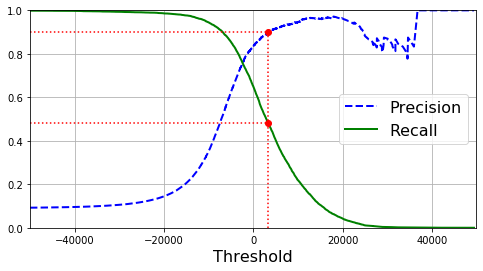

In [70]:
#fancy plot...
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
#save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [78]:
#"dataset" with +90% precision score
y_train_pred_90 = (y_scores >= threshold_90_precision)

print('With +90% "dataset"')
print('\tprecision: ', precision_score(y_train_5, y_train_pred_90))
print('\trecall: ', recall_score(y_train_5, y_train_pred_90))
print('\tf1: ', f1_score(y_train_5, y_train_pred_90))

With +90% "dataset"
	precision:  0.9000345901072293
	recall:  0.4799852425751706
	f1:  0.626082771896054


In [80]:
#ROC Curve
#The ROC curve plots sensitivity(recall, tpr) versus 1-specificity(fpr)

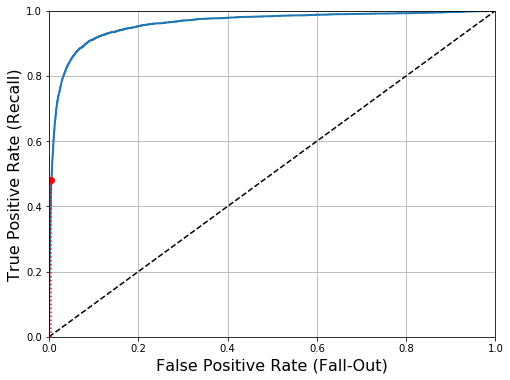


Area under curve(AUC):  0.9604938554008616


In [83]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

#another fancy plot...
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
#save_fig("roc_curve_plot")                                    # Not shown
plt.show()

#auc
print('\nArea under curve(AUC): ', roc_auc_score(y_train_5, y_scores))

In [88]:
#Training a RandomForestClassifier and comparing its ROC curve to the SGD ROC curve
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [90]:
y_scores_forest[:7]

array([0.89, 0.01, 0.04, 0.  , 0.01, 0.  , 0.  ])

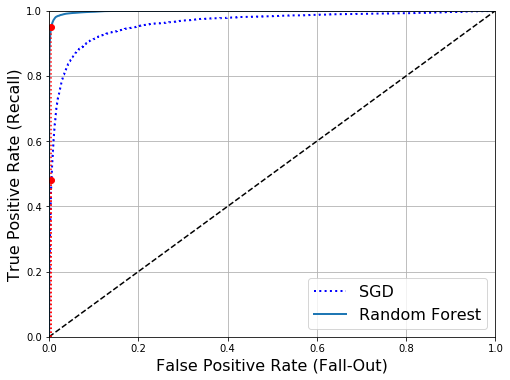

In [91]:
#another fancy plot... (should learn how to do them right)
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

In [96]:
print('Metrics:')
print('\tArea under curve(AUC): ', roc_auc_score(y_train_5, y_scores_forest))
#as we can see through the plot, the AUC of random forest is MUCH higher than the AUC of SGD

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3) #binary classification
print('\n\tprecision: ', precision_score(y_train_5, y_train_pred_forest))
print('\trecall: ', recall_score(y_train_5, y_train_pred_forest))
print('\tf1: ', f1_score(y_train_5, y_train_pred_forest))
#such result much wow

Metrics:
	Area under curve(AUC):  0.9983436731328145

	precision:  0.9905083315756169
	recall:  0.8662608374838591
	f1:  0.9242275142688446
